In [27]:
import os
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 停用词列表
stopwords = []

# 加载停用词列表
with open('../stopwords/cn_stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

with open('../stopwords/hit_stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

with open('../stopwords/baidu_stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

with open('../stopwords/scu_stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

##### 对中文分词和虚词过滤的简单测试

In [3]:
def preprocess(text):
    # 分词
    words = jieba.lcut(text)
    # 去除虚词
    words = [word for word in words if word not in stopwords]
    # 返回处理后的词语列表
    return words

text = '这书是我昨天在杭电图书馆借的的。'
words = preprocess(text)
print(words)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.654 seconds.
Prefix dict has been built successfully.


['这书', '昨天', '杭电', '图书馆']


中文分词和虚词过滤的顺序是有一定影响的。通常情况下，应该先进行中文分词，再进行虚词过滤。原因如下：
首先，如果我们先进行虚词过滤，将虚词删除后再进行中文分词，可能会导致一些实质意义的词语被拆分开来，进而影响分析的准确性。

In [4]:
# 读取train数据集
data = []
labels = []
for root, dirs, files in os.walk('./Chinese_Text_Classification_Task_Dataset/train'):
    print('dealing with {}'.format(root.split('/')[-1]))
    for file in files:
        with open(os.path.join(root, file), 'r', encoding='GB2312',errors='ignore') as f:
            content = f.read()
            # 中文分词
            words = jieba.lcut(content)
            # 过滤停用词和数字
            words = [word for word in words if word not in stopwords and not word.isdigit()]

            data.append(' '.join(words))
            labels.append(root.split('/')[-1])

dealing with train
dealing with C19-Computer
dealing with C3-Art
dealing with C39-Sports
dealing with C31-Enviornment
dealing with C38-Politics
dealing with C34-Economy


In [5]:
# 检测是否data已包含全部的训练数据
len(data)

1200

In [6]:
# 使用TF-IDF算法将文本转换成向量
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)
y = labels

In [7]:
selector = SelectKBest(chi2, k=1000)  # 选择1000个特征
selector.fit(X, y)
X = selector.transform(X)

In [8]:
# 计算特征权重
features = vectorizer.get_feature_names_out() 
feature_weights = selector.scores_
sorted_idx = feature_weights.argsort()[::-1][:1000]
for idx in sorted_idx:
    print(features[idx], feature_weights[idx])

政治 232.18988696511764
体育 171.50252478876223
艺术 152.14737372724562
经济 111.86045413700113
民主 67.7423807227464
运动员 59.81317596191297
文艺 57.73554666621497
土壤 55.42793106987776
干部 46.73408747440439
社会主义 45.90343055805633
文学 44.441673746553356
作品 41.60925430683575
训练 40.957317911242434
企业 40.77487805968941
运动 40.74484369375309
知识经济 40.69489579010183
增长 36.66636339978162
投资 36.657844935363165
全球化 36.530872101813344
算法 35.241281975648924
创作 31.581492626507906
数据库 31.53248020086708
agent 30.628798395771543
奥运会 30.096371342512917
比赛 29.528253119897656
小说 29.429348587832717
健身 28.665530032812786
竞技 28.645102508433187
数据 27.69283225804056
服务器 27.365403149939773
权力 27.255297961674426
电影 27.241404269392437
领导 27.15920420999553
建设 26.75544965994526
审美 25.639874328671883
社会 25.046767072049978
用户 24.922787064855417
系统 24.517096878494836
发展 23.81508808467983
学生 23.197911804650168
人民 22.9928288222716
邓小平 22.85024997825185
浓度 22.735867477948062
环境 22.599375192271506
制度 22.46495487460147
艺术家 22.29009476118

In [9]:
# 构建分类器
svm_clf = SVC(kernel='linear')
svm_clf.fit(X, y)

SVC(kernel='linear')

In [10]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X, y)

KNeighborsClassifier()

In [11]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X, y)

RandomForestClassifier()

In [12]:
clf = [svm_clf,knn_clf,rf_clf]

##### 模型测试

In [13]:
# 对新的文本进行分类
test_text = '创作艺术需要社会的包容'
words = preprocess(test_text)
print(words)
X_new = vectorizer.transform([' '.join(words)])
X_new = selector.transform(X_new)
y_new = rf_clf.predict(X_new)
print('Predicted Label:', y_new[0])

['创作', '艺术', '社会', '包容']
Predicted Label: C3-Art


In [14]:
# 读取train数据集
test_data = []
test_labels = []
text_file = []
for root, dirs, files in os.walk('./Chinese_Text_Classification_Task_Dataset/test'):
    print('dealing with {}'.format(root.split('/')[-1]))
    for file in files:
        text_file.append(file)
        with open(os.path.join(root, file), 'r', encoding='GB2312',errors='ignore') as f:
            content = f.read()
            # 中文分词
            words = jieba.lcut(content)
            # 过滤停用词和数字
            words = [word for word in words if word not in stopwords and not word.isdigit()]

            test_data.append(' '.join(words))
            test_labels.append(root.split('/')[-1])

dealing with test
dealing with C19-Computer
dealing with C3-Art
dealing with C39-Sports
dealing with C31-Enviornment
dealing with C38-Politics
dealing with C34-Economy


In [15]:
def diff_clf_pred(clf_model=svm_clf):
    y_pred = []
    for i in range(len(test_data)):
        X_new = vectorizer.transform([test_data[i]])
        X_new = selector.transform(X_new)
        y_new = clf_model.predict(X_new)
        y_pred.append(y_new[0])
    return y_pred

In [16]:
svm_pred = diff_clf_pred(clf_model=svm_clf)

In [17]:
knn_pred = diff_clf_pred(clf_model=knn_clf)

In [18]:
rf_pred = diff_clf_pred(clf_model=rf_clf)

In [19]:
print("SVM classification report:\n", classification_report(test_labels, svm_pred))

SVM classification report:
                  precision    recall  f1-score   support

   C19-Computer       0.95      0.99      0.97       100
         C3-Art       0.99      0.97      0.98       100
C31-Enviornment       0.85      1.00      0.92       100
    C34-Economy       0.98      0.91      0.94       100
   C38-Politics       0.98      0.93      0.95       100
     C39-Sports       1.00      0.92      0.96       100

       accuracy                           0.95       600
      macro avg       0.96      0.95      0.95       600
   weighted avg       0.96      0.95      0.95       600



In [20]:
print("KNN classification report:\n", classification_report(test_labels, knn_pred))

KNN classification report:
                  precision    recall  f1-score   support

   C19-Computer       0.94      0.59      0.72       100
         C3-Art       0.53      0.99      0.69       100
C31-Enviornment       0.97      0.83      0.89       100
    C34-Economy       0.95      0.72      0.82       100
   C38-Politics       0.84      0.89      0.86       100
     C39-Sports       1.00      0.81      0.90       100

       accuracy                           0.81       600
      macro avg       0.87      0.81      0.81       600
   weighted avg       0.87      0.81      0.81       600



In [21]:
print("Random Forest classification report:\n", classification_report(test_labels, rf_pred))

Random Forest classification report:
                  precision    recall  f1-score   support

   C19-Computer       1.00      1.00      1.00       100
         C3-Art       0.97      1.00      0.99       100
C31-Enviornment       1.00      1.00      1.00       100
    C34-Economy       0.97      0.93      0.95       100
   C38-Politics       0.92      0.97      0.95       100
     C39-Sports       1.00      0.96      0.98       100

       accuracy                           0.98       600
      macro avg       0.98      0.98      0.98       600
   weighted avg       0.98      0.98      0.98       600



In [22]:
def print_confusion_matrix(clf_pred=svm_pred):
    cm = confusion_matrix(test_labels, clf_pred)
    print("Confusion matrix:")
    print(cm)
    return cm

In [23]:
print('svm_pred',end=" ")
svm_cm = print_confusion_matrix(svm_pred)
print('knn_pred',end=" ")
knn_cm = print_confusion_matrix(knn_pred)
print('rf_pred',end=" ")
rf_cm = print_confusion_matrix(rf_pred)

svm_pred Confusion matrix:
[[ 99   0   1   0   0   0]
 [  0  97   3   0   0   0]
 [  0   0 100   0   0   0]
 [  1   0   6  91   2   0]
 [  0   1   4   2  93   0]
 [  4   0   4   0   0  92]]
knn_pred Confusion matrix:
[[59 40  0  1  0  0]
 [ 0 99  0  0  1  0]
 [ 1 14 83  0  2  0]
 [ 1 13  2 72 12  0]
 [ 0  9  0  2 89  0]
 [ 2 13  1  1  2 81]]
rf_pred Confusion matrix:
[[100   0   0   0   0   0]
 [  0 100   0   0   0   0]
 [  0   0 100   0   0   0]
 [  0   0   0  93   7   0]
 [  0   2   0   1  97   0]
 [  0   1   0   2   1  96]]


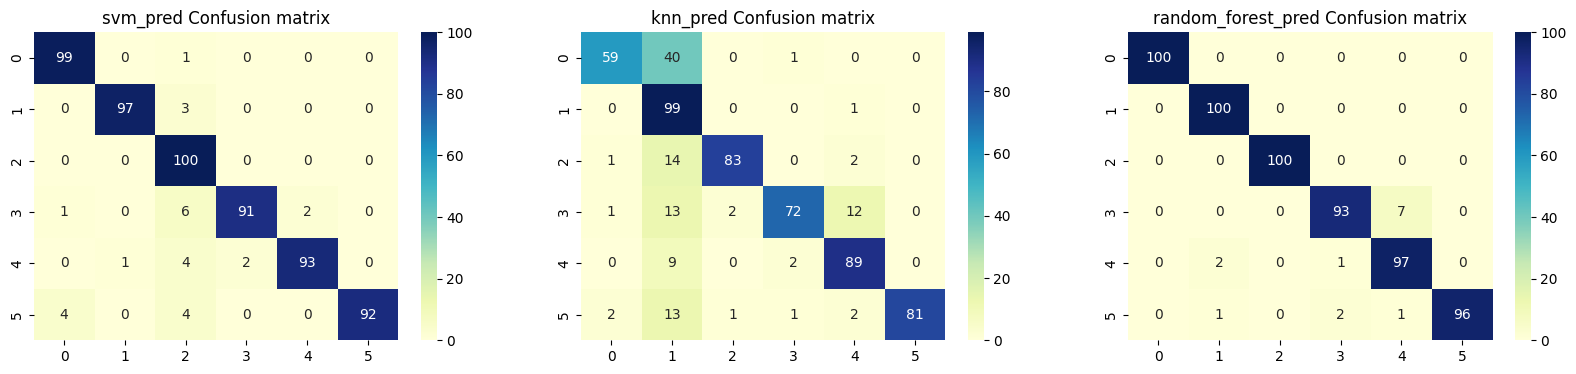

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4)) 
sns.heatmap(svm_cm, annot=True, fmt='d', cmap="YlGnBu", ax=axs[0]) 
sns.heatmap(knn_cm, annot=True, fmt='d', cmap="YlGnBu", ax=axs[1]) 
sns.heatmap(rf_cm, annot=True, fmt='d', cmap="YlGnBu", ax=axs[2])
axs[0].set_title('svm_pred Confusion matrix') 
axs[1].set_title('knn_pred Confusion matrix') 
axs[2].set_title('random_forest_pred Confusion matrix') 
plt.show()

In [31]:
svm_acc = accuracy_score(test_labels, svm_pred)
knn_acc = accuracy_score(test_labels, knn_pred)
rf_acc = accuracy_score(test_labels, rf_pred)

print("svm 准确率：{:.2f}%".format(svm_acc * 100))
print("knn 准确率：{:.2f}%".format(knn_acc * 100))
print("random forest 准确率：{:.2f}%".format(rf_acc * 100))

svm 准确率：95.33%
knn 准确率：80.50%
random forest 准确率：97.67%


In [25]:
# 显示一个错误分类的案例
for i in range(len(svm_pred)):
    if rf_pred[i]!=test_labels[i]:
        print("rf_pred is {}, while real label is {}".format(rf_pred[i],test_labels[i]))
        print(text_file[i])
        break

rf_pred is C34-Economy, while real label is C39-Sports
C39-Sports0198.txt


In [26]:
with open('./Chinese_Text_Classification_Task_Dataset/test/C39-Sports/C39-Sports0198.txt', 'r', encoding='GB2312', errors='ignore') as f:
    content = f.read()

print(content)

【 文献号 】2-3871
【原文出处】新闻与传播研究
【原刊地名】京
【原刊期号】199601
【原刊页号】11-17
【分 类 号】G6
【分 类 名】新闻学
【 作  者 】张西明
【复印期号】199603
【 标  题 】中国电视业的现状和问题
【 正  文 】
    截至1995年年中，中国的电视机拥有量达2.5亿台， 电视观众突破8亿，无线电视台为970余座，有线电视台则多达1200 多家， 另外还有
1000家左右的教育台。电视行业的人通常用“三个一千”的形象说法来描绘这种格局，即“无线一千，有线一千，教育台一千”。〔1 〕从这
组数字看，中国是无可争议的“世界上最大的视听市场”，而且是最繁忙的市场。可以这样说，每天我们的视野中都有各式各样新的建筑拔地
而起，与此同时，我们身边看不见的空间里也每时每刻都在涌现着新的视听信号，渐渐地把电视机的频道全部占满。另一方面，犹如一处处欣
欣向荣的建筑工地背后隐藏着这样那样的无序和混乱一样，透过电视的卫星信号、微波信号和有线电缆展现出的勃勃生机，也能明显感觉到夹
杂其中的纷乱、混乱和浮躁。浮躁中透着勃勃生机，可以说是今天中国电视业的写照，而且也是其可以预见的明天。
    本文意在总结当前我国电视业的主要发展趋势和特点，特别是电视行业内部对现状和发展的看法，笔者希望通过这篇文章与有关专家学者
讨论这个领域的管理和发展问题。
            一、有线电视的发展及遇到的问题
    我国新兴的电视业市场中，发展情况并不是铁板一块。一些新的部门、部类正在崛起，一些传统部门则不得不挖潜、革新。这里只能择要
对一些方面进行描述，破题之处是近年来电视业中发展较快、问题也较多的方面军――有线电视。
    我国的有线电视，自80年代中期开始出现，最近几年迅猛发展。有线电视的优点，是能使观众同时收看到十几个乃至几十个频道，这在较
大程度上丰富了电视屏幕和观众的文化生活。截至1995年5月份， 我国有线电视用户终端数为3000万，经广播电影电视部批准的有线台目前已
达1200座。〔2 〕实际的用户终端数和有线电视台数量远远超过了前两个数。由于经济利益的驱动，全国各地发展有线电视的积极性都非常高
。如在经济实力并不很强的湖南，一般的县、市都安装了有线电视，现在正向乡镇延伸。有的地方，十几个乡都安装了有线电视。按广播电影
电视

##### 通过查看错误案例的原文，发现似乎并不是体育板块的，可能是部分数据标注出现问题